In [66]:
import corner
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange


jax.config.update("jax_enable_x64", True)
%matplotlib widget

## Generate some data

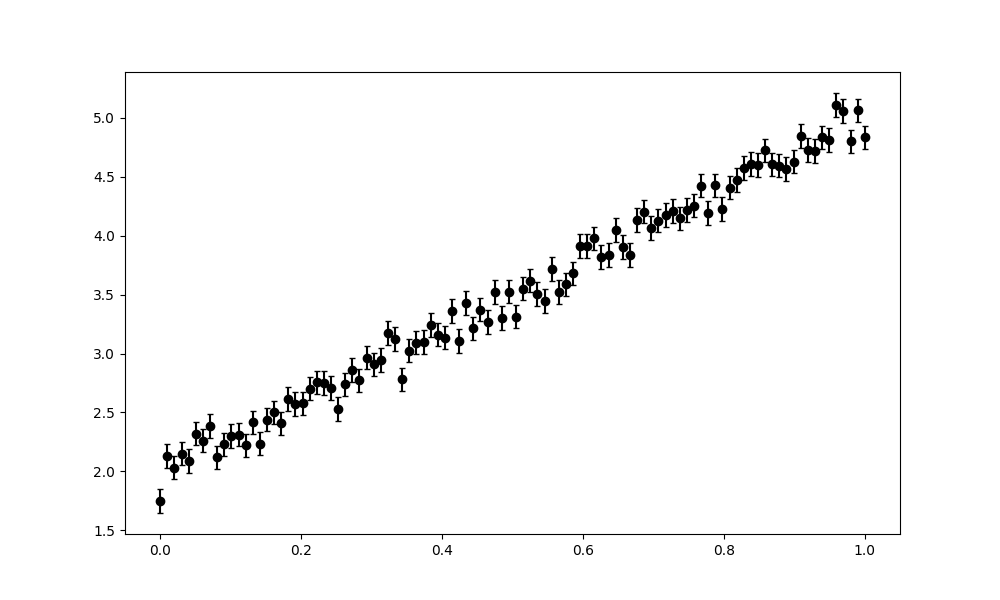

In [2]:
key = jax.random.key(0)  # random number generator key

@jax.jit
def mdl(x, pars):
    """
    The true model of the data. For now it is a simple polynomial.

    Parameters
    ----------
    x : ndarray
        Independent variable.
    pars : ndarray
        Model parameters. In this case, the polynomial coefficients in increasing order (constant term first).
        We will aim to estimate these later.

    Returns
    -------
    y : ndarray
        Dependent variable.
    
    """
    deg = len(pars)
    y = jnp.zeros_like(x)
    for i in range(deg):
        y += pars[i] * x ** i
    return y

x = jnp.linspace(0, 1, num=100)

# we start with a linear model
intercept = 2
slope = 3
true_pars = jnp.array((intercept, slope), dtype=jnp.float64)
y_obs = mdl(x, true_pars)
# add some gaussian noise
sigma = 0.1
y_obs += sigma * jax.random.normal(key, shape=x.shape, dtype=jnp.float64)

plt.figure(figsize=(10, 6))
plt.errorbar(x, y_obs, yerr=sigma, fmt="o", capsize=2, color="k")
plt.show()

## Fitting

Our data are $y_{obs}$ measured at each value of $x$. For EIGSEP, this would correspond to temperature and frequency. We guess that they're related to each other with a linear model and want to fit for the parameters of the model. For EIGSEP, the relation is more complicated but we can think of crossiant.sim as the model and we want to use the same procedure as here to fit for the parameter that is the beam.

We use stochastic gradient descent which involves guessing some values for the parameters and then updating their values until the gradient of the loss function is zero (which would correspond to the loss function itself being minimized).

In [3]:
@jax.jit
def loss_fcn(pars):
    """
    The loss function that we want to minimize. Given a choice of parameters, we find the corresponding y-values and computes
    the chi-squared error.

    Parameters
    ----------
    pars : array-like
        Model parameters.

    Returns
    -------
    float
        Chi-square error normalized by the number of data points.
    
    """
    y_fit = mdl(x, pars)
    return jnp.sum(jnp.abs(y_obs**2 - y_fit**2)) / x.size

# we can get the gradient of the loss function automatically with jax
loss_grad = jax.grad(loss_fcn)

Gradient descent summarized:

1. Start with some guess for the parameters $p$.
2. Use the forward model to generate $y_{fit}$.
3. Compute the loss and the gradient of the loss.
4. Update $p$ by moving in a direction of decreasing loss gradient.

In [19]:
p0 = jnp.array((1, 1), dtype=jnp.float64)  # our first guess for the parameters is that they're both 0

def fit(max_iter, learning_rate, initial_par=p0):
    """
    The fitting loop.

    Parameters
    ----------
    max_iter : int
        Number of iterations in the loop.
    learning_rate : float
        Hyperparameter that sets the step size (how much we update the parameters at each step)
    initial_par : ndarray
        The initial guess for the parameters.

    Returns
    -------
    par_vals : ndarray
        The parameter at each iteration.
    loss_vals : ndarray
        The value of the loss at each iteration.
    grad_vals : ndarray
        The value of the gradient of the loss at each iteraiton.
    
    """
    par_vals = []
    loss_vals = []
    grad_vals = []

    par = initial_par
    for step in trange(max_iter):
        loss = loss_fcn(par)
        grad = loss_grad(par)
        loss_vals.append(loss)
        grad_vals.append(grad)
        par -= learning_rate * grad
        par_vals.append(par)

    par_vals = jnp.array(par_vals)
    loss_vals = jnp.array(loss_vals)
    grad_vals = jnp.array(grad_vals)
    
    return par_vals, loss_vals, grad_vals

par_vals, loss_vals, grad_vals = fit(100, 0.1)

  0%|          | 0/100 [00:00<?, ?it/s]

We can see how the loss changes with the iterations below. Here, the learning rate is clearly too large because the loss starts oscillating. This indicates that the parameters are jumping between slightly larger and sligtly smaller than the optimal parameters without actually settling on the optimal parameter.

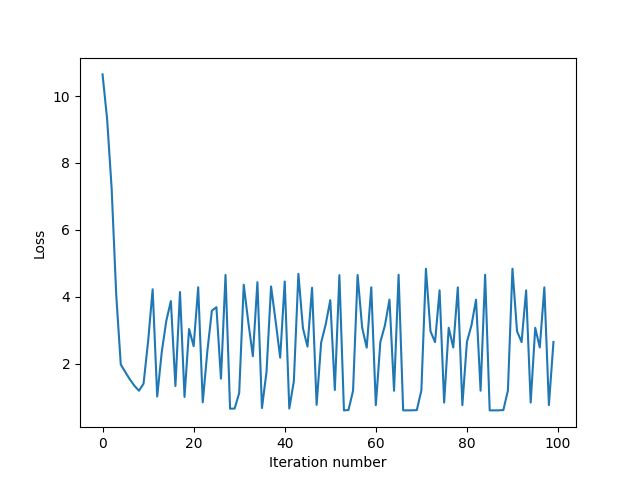

In [20]:
plt.figure()
plt.plot(loss_vals)
plt.ylabel("Loss")
plt.xlabel("Iteration number")
plt.show()

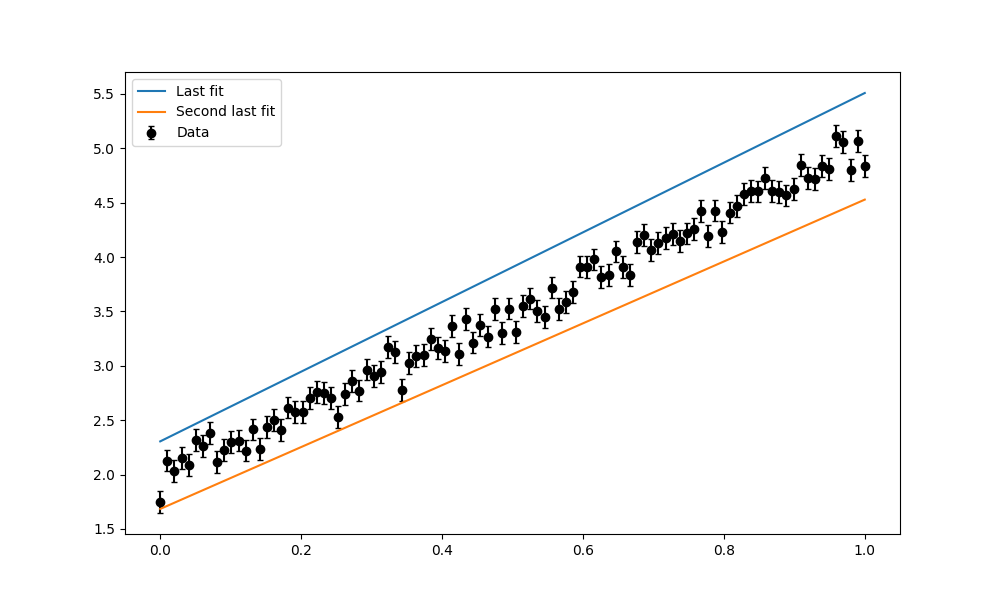

In [21]:
plt.figure(figsize=(10, 6))
plt.errorbar(x, y_obs, yerr=sigma, fmt="o", capsize=2, color="k", label="Data")
plt.plot(x, mdl(x, par_vals[-1]), label="Last fit")  # you can experiment by changing the index of par_vals here to see how it changes with iteration
plt.plot(x, mdl(x, par_vals[-2]), label="Second last fit")
# plt.plot(x, mdl(x, par_vals[20]))
# plt.plot(x, mdl(x, par_vals[21]))
plt.legend()
plt.show()

We make the learning rate smaller by a factor of 10 to see if we can fix the problem above.

  0%|          | 0/100 [00:00<?, ?it/s]

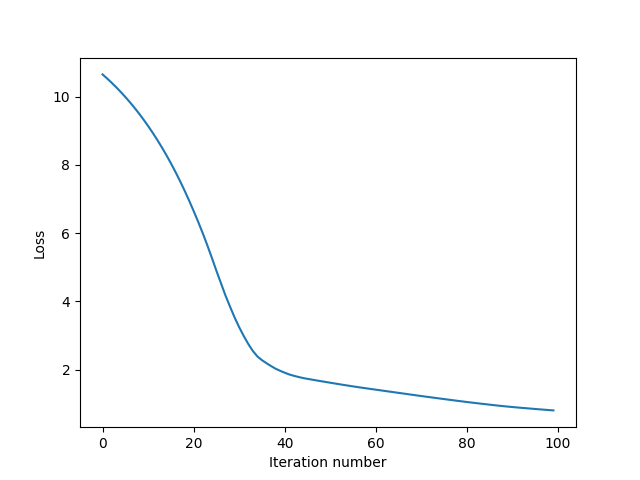

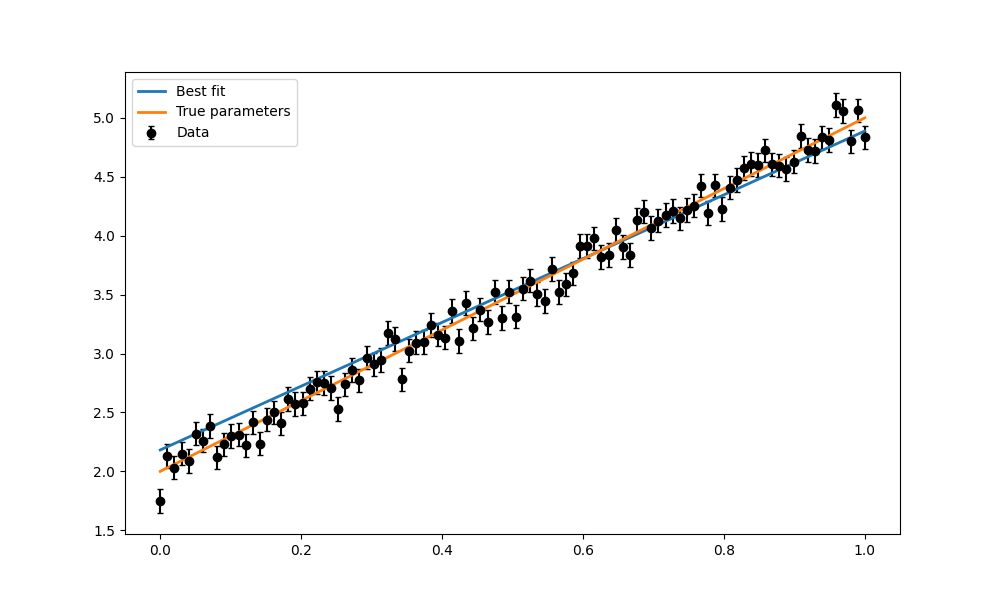

In [22]:
par_vals, loss_vals, grad_vals = fit(100, 0.01)  # new learning rate is 0.01

plt.figure()
plt.plot(loss_vals)
plt.ylabel("Loss")
plt.xlabel("Iteration number")
plt.show()


plt.figure(figsize=(10, 6))
plt.errorbar(x, y_obs, yerr=sigma, fmt="o", capsize=2, color="k", label="Data")
plt.plot(x, mdl(x, par_vals[-1]), label="Best fit", lw=2)
plt.plot(x, mdl(x, true_pars), label="True parameters", lw=2)
plt.legend()
plt.show()

We can experiement with max number of iterations and learning rate until we get a fit we're satisfied with. But obviously in real life, we don't know what the true parameters are so it's hard to say when we are satisfied.

## Statistics

While the gradient descent ideally makes the parameter get better and better, this is not guaranteed. There's some randomness to it and there's no guarantee that the best parameter is the last one. The more proper way of doing it is to take the average of the parameters that we've explored and even plot the distribution. If the fitting is well-behaved, it will be the case that the optimizer will spend most of its time close to the best value and less and less time further away. In fact, the distribution of the parameters explored will converge to the underlying posterior distribution that tells us about how confident we are in our belief of the measured value.

  0%|          | 0/1000 [00:00<?, ?it/s]

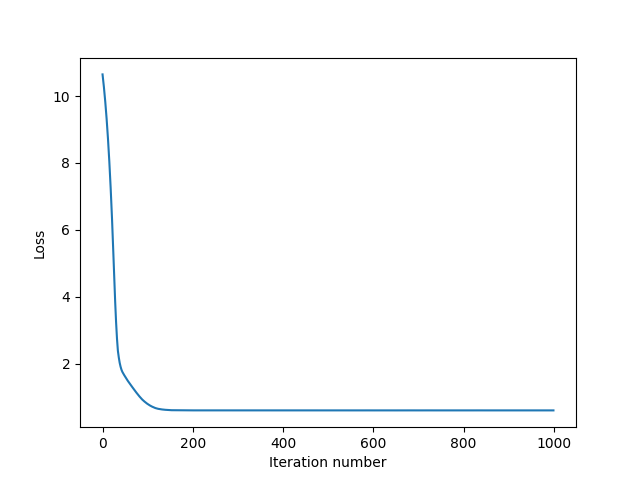

In [23]:
# to get more interesting statistics, we do 1000 steps
par_vals, loss_vals, grad_vals = fit(1000, 0.01)


plt.figure()
plt.plot(loss_vals)
plt.ylabel("Loss")
plt.xlabel("Iteration number")
plt.show()


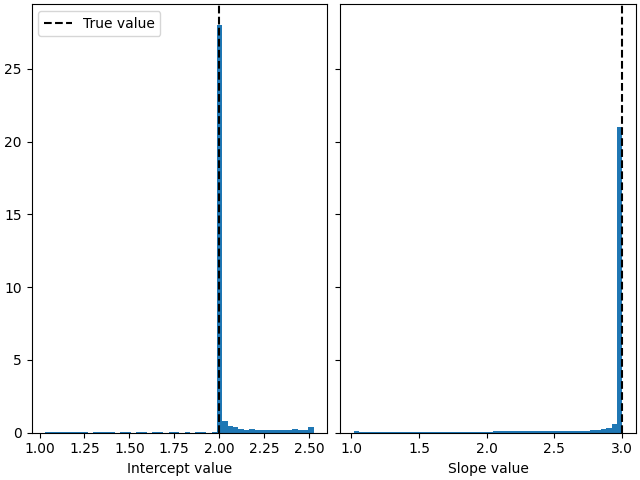

In [36]:
# the most basic thing to do is to make histograms of the parameters
fig, axs = plt.subplots(ncols=2, constrained_layout=True, sharey=True)
axs[0].hist(par_vals[:, 0], bins=50, density=True)
axs[0].axvline(true_pars[0], c="k", ls="--", label="True value")
axs[0].set_xlabel("Intercept value")
axs[0].legend()
axs[1].hist(par_vals[:, 1], bins=50, density=True)
axs[1].axvline(true_pars[1], c="k", ls="--", label="True value")
axs[1].set_xlabel("Slope value")
plt.show()

We see that the distributions are not very symmetrical around the best value, but that they generally did converge to the right parameter. We compute the mean and standard devation and compare to the true values.

Intercept:
True: 2.0
Best fit: 2.0 +- 0.1
Slope:
True: 3.0
Best fit: 2.9 +- 0.3


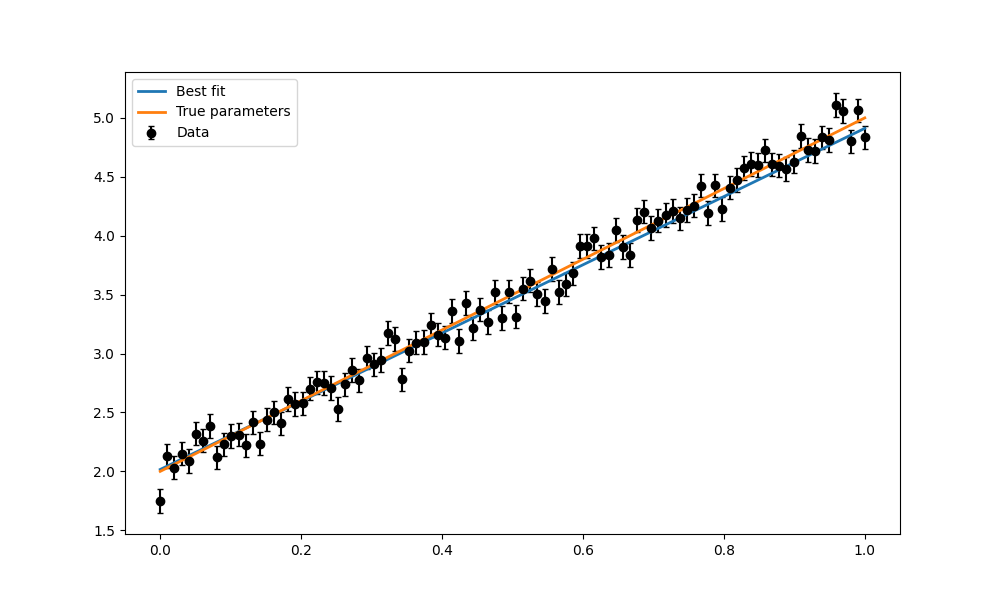

In [39]:
best_params = jnp.mean(par_vals, axis=0)
fit_sigma = jnp.std(par_vals, axis=0)

print("Intercept:")
print(f"True: {true_pars[0]:.1f}")
print(f"Best fit: {best_params[0]:.1f} +- {fit_sigma[0]:.1f}")
print("Slope:")
print(f"True: {true_pars[1]:.1f}")
print(f"Best fit: {best_params[1]:.1f} +- {fit_sigma[1]:.1f}")

plt.figure(figsize=(10, 6))
plt.errorbar(x, y_obs, yerr=sigma, fmt="o", capsize=2, color="k", label="Data")
plt.plot(x, mdl(x, best_params), label="Best fit", lw=2)
plt.plot(x, mdl(x, true_pars), label="True parameters", lw=2)
plt.legend()
plt.show()

There are several things to do to make the statistics a bit more accurate. One is discarding the first 20% of the iterations. This is often referred to as burn-in. We do this because our initial guess is just random and is not necessarily close to the ideal parameters. But since we had to start somewhere, the fitter will spend time around those initial parameters. To minimize the effect of this random choice, we only use data points taken after some time, when we can assume that we're reasonably far from the start point.

We can also run the iterations many times in parallel with different starting points to further reduce this impact. Multiple independent runs can also give useful statistics about how good the fits are and if they're converging. It's also possible to thin the samples, by keeping for example every 10th parameter sample. This reduces correlations between samples and make the dsitribution more robust. The downside of course is that you have to run the fitter for 10 times as long to get as many data points in your statistics.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

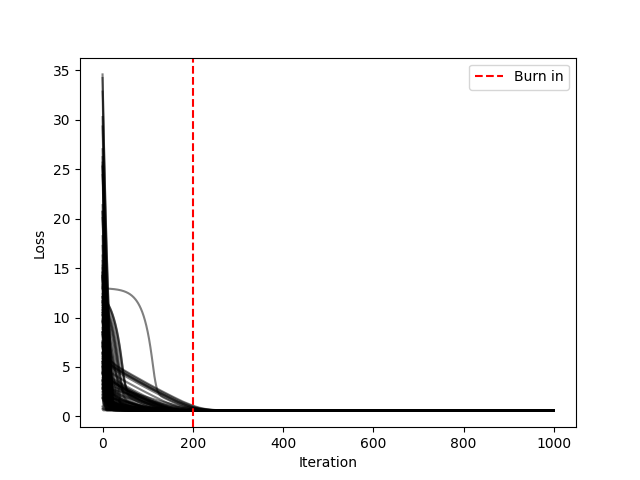

In [70]:
N_runs = 100  # number of runs
max_iter = 1000  # iterations per run
learning_rate = 0.01
burn_in = 0.2
N_burn = int(burn_in * max_iter)
par_vals = jnp.empty((N_runs, max_iter, true_pars.size), dtype=jnp.float64)
loss_vals = jnp.empty((N_runs, max_iter), dtype=jnp.float64)

# for the initial guess, we pick randomly in the range 0 to +5 for both params
# this choice itself seem kind of arbitrary but it reflects some prior knowledge we have about the parameters (we have reason to believe these are close to true parameters)
# the notion of prior knowledge and prior distributions will be covered more in detail later, when we discuss Bayesian statistics

next_key = jax.random.key(1420)
for run in trange(N_runs):
    next_key, key = jax.random.split(next_key)
    p0 = jax.random.uniform(key, shape=true_pars.shape, dtype=jnp.float64, minval=0, maxval=5)  # initial parameter
    pv, lv, gv = fit(max_iter, learning_rate, initial_par=p0)
    par_vals = par_vals.at[run].set(pv)  # note that updating arrays in JAX is different from numpy, and a little annoying
    loss_vals = loss_vals.at[run].set(lv)

plt.figure()
plt.plot(loss_vals.T, c="k", alpha=0.5)
plt.axvline(N_burn, ls="--", c="red", label="Burn in")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

par_vals = par_vals[:, N_burn:]
loss_vals = loss_vals[:, N_burn:]

In [71]:
best_params = jnp.mean(par_vals, axis=1)
fit_sigma = jnp.std(par_vals, axis=1)

print(f"True intercept: {true_pars[0]:.3f}")
print("Best fit intercept:")
for i in range(N_runs):
    print(f"{best_params[i, 0]:.3f} +- {fit_sigma[i, 0]:.3f}")
print(f"True slope: {true_pars[1]:.3f}")
print("Best fit slope:")
for i in range(N_runs):
    print(f"{best_params[i, 1]:.3f} +- {fit_sigma[i, 1]:.3f}")


True intercept: 2.000
Best fit intercept:
1.996 +- 0.001
1.997 +- 0.004
1.997 +- 0.002
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
2.002 +- 0.023
1.995 +- 0.003
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.995 +- 0.004
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.002
1.996 +- 0.001
1.996 +- 0.001
2.003 +- 0.026
2.005 +- 0.032
1.996 +- 0.002
2.010 +- 0.048
1.996 +- 0.001
2.006 +- 0.036
1.996 +- 0.001
1.997 +- 0.002
1.996 +- 0.001
1.997 +- 0.002
1.997 +- 0.005
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.002
1.996 +- 0.001
2.005 +- 0.033
1.996 +- 0.001
1.990 +- 0.020
1.997 +- 0.002
1.997 +- 0.005
1.996 +- 0.001
1.996 +- 0.001
1.997 +- 0.002
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.997 +- 0.004
1.996 +- 0.001
1.996 +- 0.001
1.996 +- 0.001
1.997 +- 0.003
1.996 +- 0.001
1.997 +- 0.003
1.996 +- 0.001
2.008 +- 0.043
1.996 +- 0.001
1.996 +- 0.002
1.986 +- 0.034
1.996 +- 0.001
1.996 +- 0.00

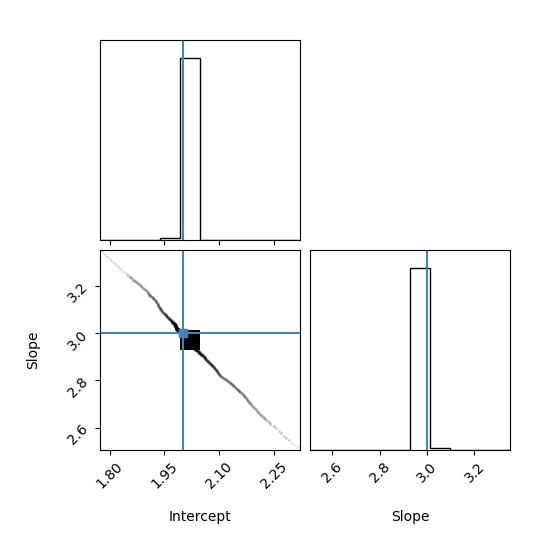

In [74]:
# we can make the histograms a bit cooler with the corner package
_ = corner.corner(np.asarray(par_vals).reshape(-1, 2), bins=10, labels=["Intercept", "Slope"], truths=true_pars)

Intercept:
True: 2.000
Best fit: 1.997 +- 0.011
Slope:
True: 3.000
Best fit: 3.001 +- 0.018


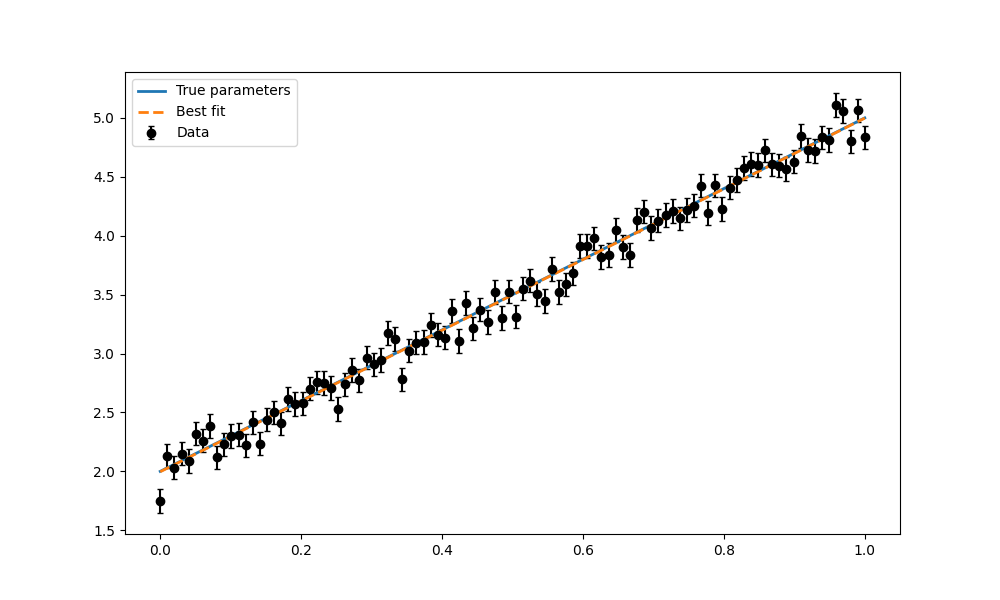

In [78]:
best_params = jnp.mean(par_vals.reshape(-1, 2), axis=0)
fit_sigma = jnp.std(par_vals.reshape(-1, 2), axis=0)

print("Intercept:")
print(f"True: {true_pars[0]:.3f}")
print(f"Best fit: {best_params[0]:.3f} +- {fit_sigma[0]:.3f}")
print("Slope:")
print(f"True: {true_pars[1]:.3f}")
print(f"Best fit: {best_params[1]:.3f} +- {fit_sigma[1]:.3f}")

plt.figure(figsize=(10, 6))
plt.errorbar(x, y_obs, yerr=sigma, fmt="o", capsize=2, color="k", label="Data")
plt.plot(x, mdl(x, true_pars), label="True parameters", lw=2)
plt.plot(x, mdl(x, best_params), label="Best fit", lw=2, ls="--")
plt.legend()
plt.show()

Finally (for now), we can make this a bit harder by increasing the noise on the data.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

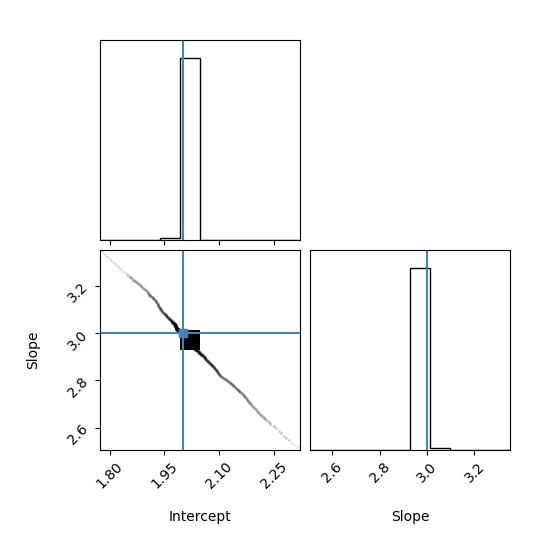

In [79]:
y_obs = mdl(x, true_pars)
# add some gaussian noise
sigma = 1.
y_obs += sigma * jax.random.normal(key, shape=x.shape, dtype=jnp.float64)


par_vals = jnp.empty((N_runs, max_iter, true_pars.size), dtype=jnp.float64)
loss_vals = jnp.empty((N_runs, max_iter), dtype=jnp.float64)
next_key = jax.random.key(1420)
for run in trange(N_runs):
    next_key, key = jax.random.split(next_key)
    p0 = jax.random.uniform(key, shape=true_pars.shape, dtype=jnp.float64, minval=0, maxval=5)  # initial parameter
    pv, lv, gv = fit(max_iter, learning_rate, initial_par=p0)
    par_vals = par_vals.at[run].set(pv)  # note that updating arrays in JAX is different from numpy, and a little annoying
    loss_vals = loss_vals.at[run].set(lv)

par_vals = par_vals[:, N_burn:]
loss_vals = loss_vals[:, N_burn:]

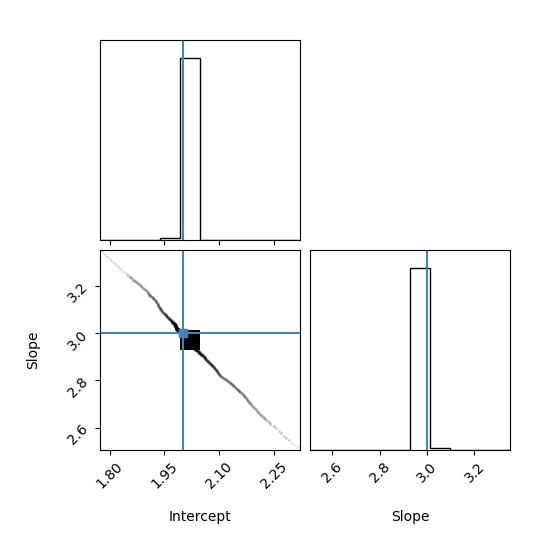

In [80]:
_ = corner.corner(np.asarray(par_vals).reshape(-1, 2), bins=10, labels=["Intercept", "Slope"], truths=true_pars)

Intercept:
True: 2.000
Best fit: 1.997 +- 0.011
Slope:
True: 3.000
Best fit: 3.001 +- 0.018


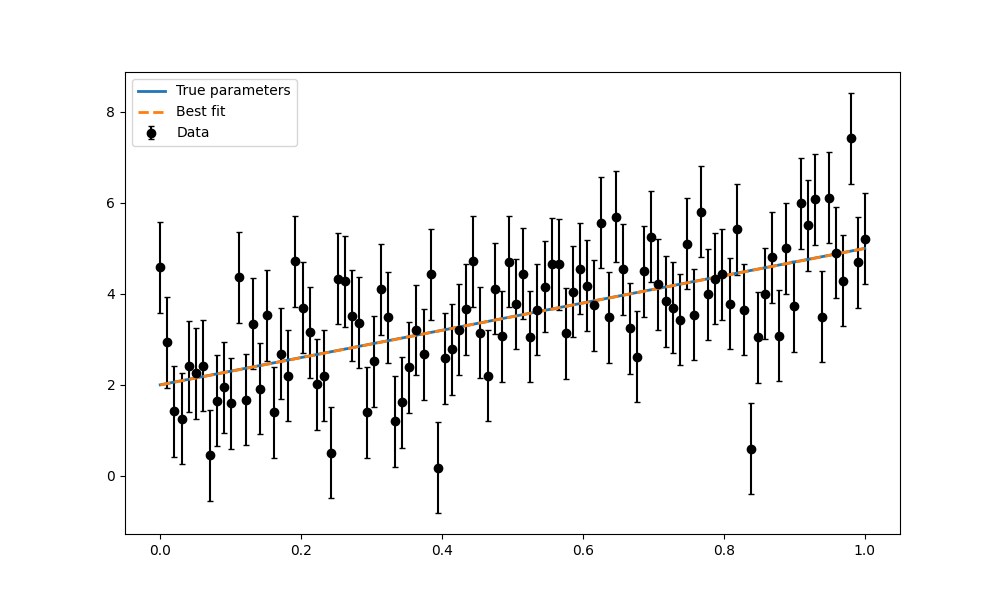

In [81]:
best_params = jnp.mean(par_vals.reshape(-1, 2), axis=0)
fit_sigma = jnp.std(par_vals.reshape(-1, 2), axis=0)

print("Intercept:")
print(f"True: {true_pars[0]:.3f}")
print(f"Best fit: {best_params[0]:.3f} +- {fit_sigma[0]:.3f}")
print("Slope:")
print(f"True: {true_pars[1]:.3f}")
print(f"Best fit: {best_params[1]:.3f} +- {fit_sigma[1]:.3f}")

plt.figure(figsize=(10, 6))
plt.errorbar(x, y_obs, yerr=sigma, fmt="o", capsize=2, color="k", label="Data")
plt.plot(x, mdl(x, true_pars), label="True parameters", lw=2)
plt.plot(x, mdl(x, best_params), label="Best fit", lw=2, ls="--")
plt.legend()
plt.show()